# Intro to Bayes and Qinfer

In this notebook, we will introduce Bayesian parameter estimation and the sequential Monte Carlo algorithm implemented by **Qinfer**. To this end, suppose we have a coin that we do not know the bias $p$ of. We will guess what $p$ is by flipping the coin many times. 

If we knew the bias, we could determine the exact distribution of the number of "Heads" we would see. If we label the number of flips $N$ and the number of heads $n$, then the distribution of $n$ is of course a Binomial distribution
$$
\operatorname{Pr}(n|p) = \binom{N}{n} p^n (1-p)^{N-n}.
$$

Now suppose we have flipped the coin and $n$ heads did actually occur in $N$ flips. What is the distribution of $p|n$? The answer is given by Bayes' rule:
$$
\operatorname{Pr}(n|p) = \frac{\operatorname{Pr}(n|p)\operatorname{Pr}(p)}{\operatorname{Pr}(n)},
$$
where $\operatorname{Pr}(n|p)$ is called the likelihood function, $\operatorname{Pr}(p)$ the prior, $\operatorname{Pr}(p|n)$ the posterior and $\operatorname{Pr}(n)$ is called the evidence. The likelihood function we have determined above. The prior is the input to the problem and the evidence can be determined by normalization of probability.

The input, the prior, can be anything. A typical choice for generic problems is the uniform prior $\operatorname{Pr}(p) = 1/V$, where $V$ is the volume of the parameter space, in this case $V = 1$ since the bias can be between 0 and 1. For the uniform prior, the posterior is
$$
\operatorname{Pr}(p|n) = \frac{p^n (1-p)^{N-n}}{B(n+1,N-n+1)},
$$
where $B$ is the Beta function.

For more complicated models, such an analytic solution is not obtainable and we must turn to numerical algorithms. The algorithm we use is called sequential Monte Carlo or the particle filter. We begin by drawing $k$ samples $\{p_i\}$ from the prior and approximating it as
$$
\operatorname{Pr}(p) = \frac{1}{k}\sum_{i=1}^k \delta(p-p_i).
$$
The samples are called particles. Each particle is associated a weight $w_i$ which is conventionally set to be $1/k$ initially. The weights are updated via Bayes rule as follows:
$$
w_i(n) \mapsto \Pr(n|p_i)/k.
$$
The set of weights $\{w_i(n)\}$ are not normalized so we make one final assignment
$$
w_i(n) \mapsto \frac{w_i(n)}{\sum_j w_j(n)}.
$$
Then the posterior is approximated by
$$
\operatorname{Pr}(p) = \sum_{i=1}^k w_i(n) \delta(p-p_i).
$$

That's it; that's the basics! Now we will go through it a little more slowly using numpy, scipy and qinfer.

### Preamble

Here we import all the necessary modules as well as make the code compatible with Python 2.7.

In [36]:
from __future__ import division, print_function

import qinfer as qi
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

%matplotlib inline
try: plt.style.use('ggplot') #use nice plotting defaults if available
except: pass

### Flipping coins

Suppose we flip our coin 10 times. What does $\operatorname{Pr}(n|p)$ look like?

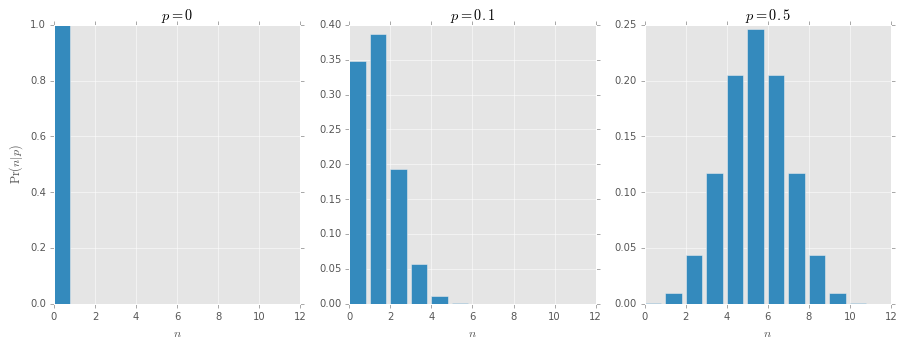

In [37]:
N = 10 # create a variable for the number of flips (go ahead and change this if you want)
n = np.arange(0,N+1) # this creates an array [0,1,...,N]

fig, axarr = plt.subplots(1, 3, figsize=(15,5)) # this sets up the figure as an matrix of subfigures with 1 row and 3 columns
dist = sp.stats.binom.pmf(n,N,0) # this is the probability mass function (pmf) of the binomial distribution for p = 0
axarr[0].bar(n,dist) # on the first (0 indexed!) subplot, make a bar plot with x-axis given by the array n and y-axis given by the pmf

# the rest is just annotation and repeating for different biases
axarr[0].set_xlabel("$n$")
axarr[0].set_ylabel("$\operatorname{Pr}(n|p)$")
axarr[0].set_title("$p=0$")

dist = sp.stats.binom.pmf(n,N,0.1)
axarr[1].bar(n,dist)
axarr[1].set_xlabel("$n$")
axarr[1].set_title("$p=0.1$")

dist = sp.stats.binom.pmf(n,N,0.5)
axarr[2].bar(n,dist)
axarr[2].set_xlabel("$n$")
axarr[2].set_title("$p=0.5$")

plt.show()

In reality, we often have data, in this case $n$, so we are interested not in $\operatorname{Pr}(n|p)$ but in $\operatorname{Pr}(p|n)$. We still use $\operatorname{Pr}(n|p)$ in Bayes' rule but think of it as a function of $p$ for fixed data $n$. Below we plot what that looks like.

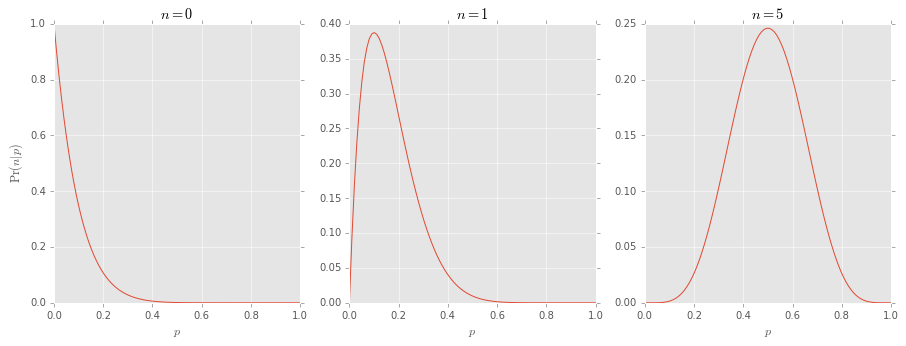

In [41]:
p = np.linspace(0,1,100) # This creates an array with 100 values between 0 and 1

fig, axarr = plt.subplots(1,3, figsize=(15,5))
likelihood = sp.stats.binom.pmf(0,N,p)
axarr[0].plot(p,likelihood)
axarr[0].set_xlabel("$p$")
axarr[0].set_ylabel("$\operatorname{Pr}(n|p)$")
axarr[0].set_title("$n=0$")

likelihood = sp.stats.binom.pmf(1,N,p)
axarr[1].plot(p,likelihood)
axarr[1].set_xlabel("$p$")
axarr[1].set_title("$n=1$")

likelihood = sp.stats.binom.pmf(5,N,p)
axarr[2].plot(p,likelihood)
axarr[2].set_xlabel("$p$")
axarr[2].set_title("$n=5$")

plt.show()

Bayes' rule states:
$$
\operatorname{Pr}(p|n) = \frac{\operatorname{Pr}(n|p)\operatorname{Pr}(p)}{\operatorname{Pr}(n)} = \frac{p^n (1-p)^{N-n}}{B(n+1,N-n+1)},
$$
For the uniform prior $\operatorname{Pr}(p) = 1$. Since this is just proportional to $\operatorname{Pr}(p|n)$ we should expect the posterior to look the same.

(Note that $\operatorname{Pr}(p|n)$ is not strictly a probability, but a density, or measure, and can be greater than 1 for any particular value of $p$ since only questions about the probability over intervals return non-zero answers.)

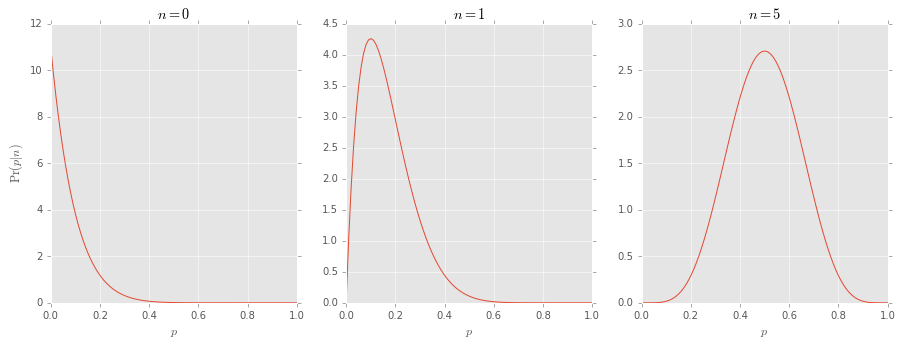

In [42]:
# rather than write it out many times, we define a function to compute the posterior which compresses further code
def posterior(p,n,N):
    return p**n*(1-p)**(N-n)/sp.special.beta(n+1,N-n+1)

# Note that notebooks have access to the variables defined in previous run cells so we do not need to redefine N and p

fig, axarr = plt.subplots(1,3, figsize=(15,5))
axarr[0].plot(p,posterior(p,0,N))
axarr[0].set_xlabel("$p$")
axarr[0].set_ylabel("$\operatorname{Pr}(p|n)$")
axarr[0].set_title("$n=0$")

axarr[1].plot(p,posterior(p,1,N))
axarr[1].set_xlabel("$p$")
axarr[1].set_title("$n=1$")

axarr[2].plot(p,posterior(p,5,N))
axarr[2].set_xlabel("$p$")
axarr[2].set_title("$n=5$")

plt.show()

### Qinfer

Now we will demonstrate how to use qinfer to get a numerical approximation to the posterior. The first task is create a `Model`.

In [84]:
# We create a model which is abstracted by the Model class, which already implements common methods 
# among models and templates what such a class needs to look like

class CoinFlipsModel(qi.abstract_model.Model):
    
    def __init__(self): # function that is called when an instance of this class is instantiated
        super(CoinFlipsModel,self).__init__() # make sure all the necessary functionality in the Model class is brought over
        
    # the following are functions that are required for the functionality of qinfer
    
    @property
    def n_modelparams(self): # the dimension of the parameter space
        return 1 # in this case it is just the bias
    
    @property
    def expparams_dtype(self): # many models will have complicated experiment design descriptions. Here it is just the number of flips
        return int # an integer
    
    def n_outcomes(self, expparams): # the number of outcomes are needed to numerically simulate experiments
        return expparams+1 # the number of flips + 1
    
    def are_models_valid(self, modelparams): # make sure any boundaries in the parameter space are respected
        return np.logical_or(modelparams>=0, modelparams<=1)[:,0] # in this case the modelparams is a bias, which must be between 0 and 1
    
    def likelihood(self, outcomes, modelparams, expparams): # finally we calculate the likelihood function
        super(CoinFlipsModel,self).likelihood(outcomes, modelparams, expparams) # again, call some necessary internal functions
        
        # the tensor storing the values of the likelihood has the following expected shape
        like = np.zeros([outcomes.shape[0],modelparams.shape[0],1])
        
        # scipy.stats.binom can vectorize over one of its arguments so we'll have to loop over the other
        for idx in range(outcomes.shape[0]):
            like[idx] = sp.stats.binom.pmf(outcomes[idx],expparams,modelparams)
            
        return like

Now that is a bit overkill for such a simple problem, but the functionality is there really for more "interesting" models. But we can see that calling `model.likelihood` gives the correct results.

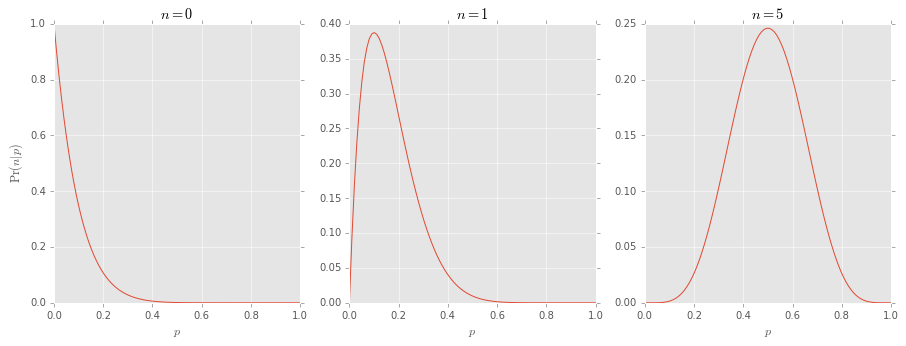

In [85]:
model = CoinFlipsModel() # this instantiates the model we just defined

expparams = N # recall that model.expparams_dtype was int and we defined N to be an integer above
outcome = np.array([0]) # in the model we asked for outcomes.shape[0], so we have to define it as an object with a shape!

fig, axarr = plt.subplots(1,3, figsize=(15,5))
# note that modelparams are expected to have atleast 2D shape; None adds an axis to the (100,) array we defined above for p
axarr[0].plot(p,model.likelihood(outcome,p[:,None],expparams)[0,:,0]) 
axarr[0].set_xlabel("$p$")
axarr[0].set_ylabel("$\operatorname{Pr}(n|p)$")
axarr[0].set_title("$n=0$")

outcome = np.array([1])
axarr[1].plot(p,model.likelihood(outcome,p[:,None],expparams)[0,:,0])
axarr[1].set_xlabel("$p$")
axarr[1].set_title("$n=1$")

outcome = np.array([5])
axarr[2].plot(p,model.likelihood(outcome,p[:,None],expparams)[0,:,0])
axarr[2].set_xlabel("$p$")
axarr[2].set_title("$n=5$")

plt.show()

The next step is creating a distribution. For most (and by most, I mean nearly all) distributions used in practice, there is built-in functionality. In particular, the uniform prior discussed above is defined in Qinfer as follows. 

In [86]:
prior = qi.distributions.UniformDistribution([0,1]) # this instantiates the built-in uniform prior over the interval [0,1]
print(prior.sample()) # prior.sample() returns a single randomly drawn sample 

[[ 0.65561735]]


The last thing to do is define an `SMCUpdater` which implements the sequential Monte Carlo algorithm. An `SMCUpdater` takes a `model` and `prior` and then its `update` function takes data and experiment parameters to produce the posterior distribution. The number of particles used controls the approximation.

In [116]:
n_particles = 1000 # the number of particles we will use

updater = qi.SMCUpdater(model,n_particles,prior) # instantiates an updater, takes the model and prior we defined above

OK, now we can plug in some data and see how well it does.

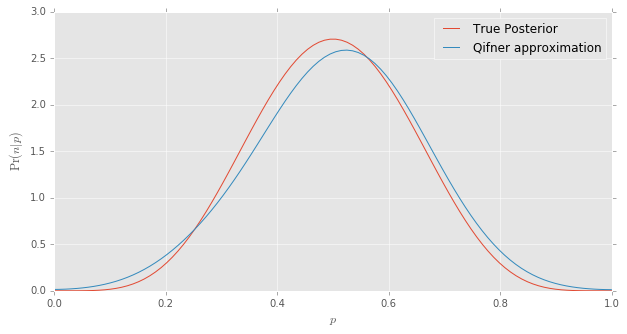

In [117]:
outcome = np.array([5]) # in the model we asked for outcomes.shape[0], so we have to define it as an object with a shape!

updater.update(outcome, expparams) # call the update function to change the state of the updater, now it stores the posterior

plt.figure(figsize = (10,5))

plt.plot(p,posterior(p,5,N), label = 'True Posterior')
updater.plot_posterior_marginal(smoothing = 0.075, other_plot_args={'label':'Qifner approximation'})

plt.xlabel("$p$")
plt.ylabel("$\operatorname{Pr}(n|p)$")

plt.legend()

Not bad! Now go forth and multiply... likelihoods by priors.